In [29]:
%load_ext autoreload
%autoreload 2

import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from src.data.utils import flatten, parallelize_dataframe
from src.data.scrape_categories import EMOJI_CATEGORIES as emoji_categories
from src.analysis.embedded import calculate_vocabulary_variation
from src.data.cldr import cldr_anns_to_df
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from settings import AMBIGUITY_VARIATION, EMOJI_CATEGORIZED

pd.set_option('mode.chained_assignment', None)

sns.set_color_codes()
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### READ in with pre computed CIs

In [2]:
AMBIGUITY_VARIATION = '/scratch/czestoch/ambiguity_variation.csv.gz'
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)
variations.head()

,emoji,vocabulary,variation,mode_embedding,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,[-9.0013e-01 -4.3639e-03 4.7695e-01 1.4165e-...,"[0.35837585716197884, 0.6267261994754275]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,[ 4.6689e-02 -2.3131e-01 6.4926e-01 -2.9223e-...,"[0.41200086324362406, 0.7542600946038873]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,[-0.10602 -0.010289 -0.25982 0.52433 ...,"[0.1401009645106064, 0.4201737316739228]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,[ 3.6664e-01 -4.0631e-01 2.3680e-01 2.9964e-...,"[0.4139707032711831, 0.7217792813700658]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,[ 0.80197 -1.3284 0.83488 -0.13458 ...,"[0.3517648566963858, 0.6258342967978838]"


In [3]:
variations['vocab_size'] = 0
for i, row in variations.iterrows():
    row = row.copy()
    variations.loc[i, "vocab_size"] = len(eval(row.vocabulary).keys())
variations.head()

,emoji,vocabulary,variation,mode_embedding,CIs,vocab_size
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,[-9.0013e-01 -4.3639e-03 4.7695e-01 1.4165e-...,"[0.35837585716197884, 0.6267261994754275]",6
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,[ 4.6689e-02 -2.3131e-01 6.4926e-01 -2.9223e-...,"[0.41200086324362406, 0.7542600946038873]",8
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,[-0.10602 -0.010289 -0.25982 0.52433 ...,"[0.1401009645106064, 0.4201737316739228]",9
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,[ 3.6664e-01 -4.0631e-01 2.3680e-01 2.9964e-...,"[0.4139707032711831, 0.7217792813700658]",16
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,[ 0.80197 -1.3284 0.83488 -0.13458 ...,"[0.3517648566963858, 0.6258342967978838]",12


In [11]:
with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

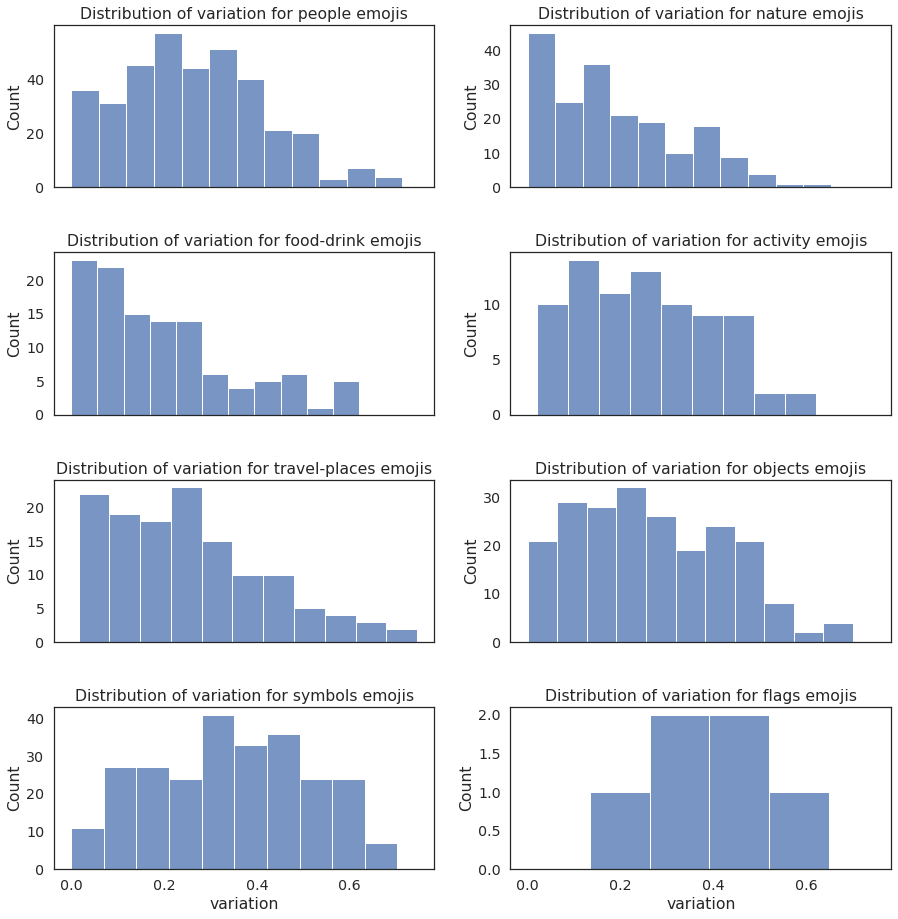

In [5]:
fig, axes = plt.subplots(4, 2, sharex=True)
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        bins='doane'
        category = emoji_categories[i*2+j]
        if category == 'flags':
            bins = 4
        sns.histplot(data=variations[variations.emoji.isin(categorized[category])].variation,\
                     bins=bins, ax=ax, legend=False)\
            .set_title(f"Distribution of variation for {category} emojis")
plt.subplots_adjust(wspace=0.2, hspace=0.4, top=1.8);

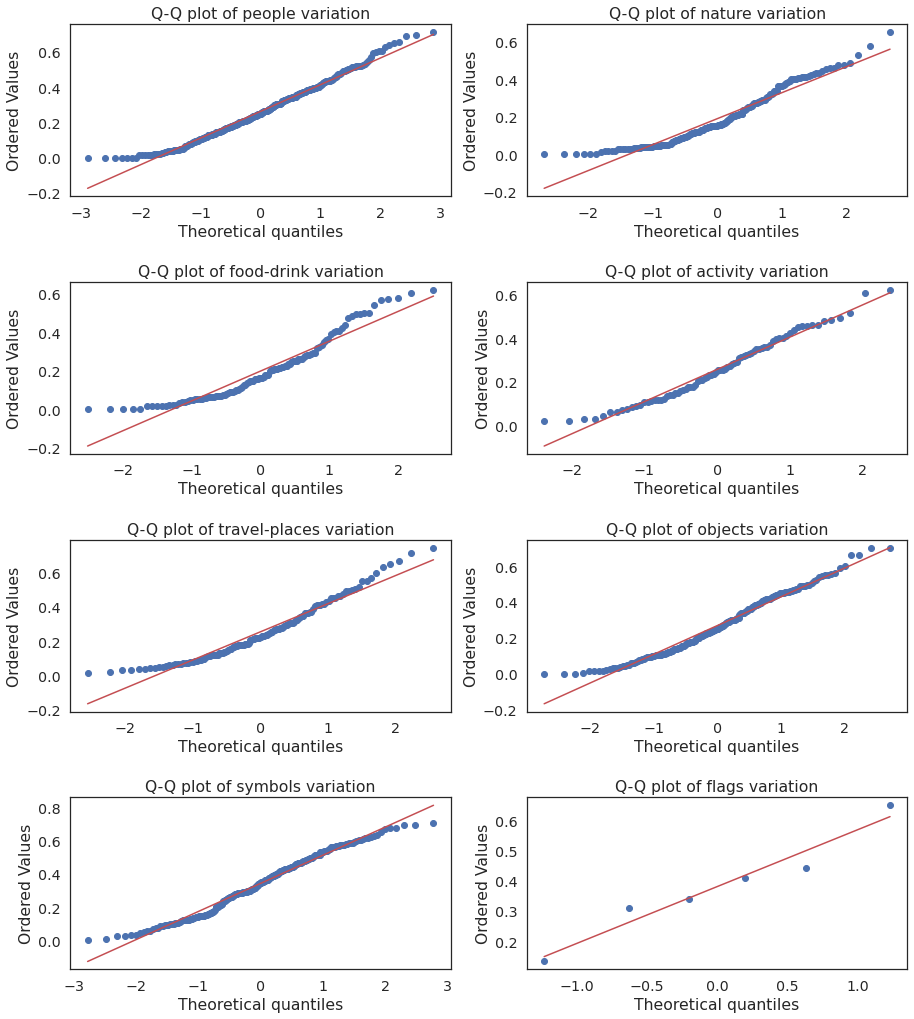

In [6]:
fig, axes = plt.subplots(4, 2)
measurements = np.random.normal(loc=20, scale=5, size=100)   
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        stats.probplot(variations[variations.emoji.isin(categorized[category])].variation,\
                       plot=ax);
        ax.set_title(f"Q-Q plot of {category} variation")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2);

### Least and most ambiguous emojis

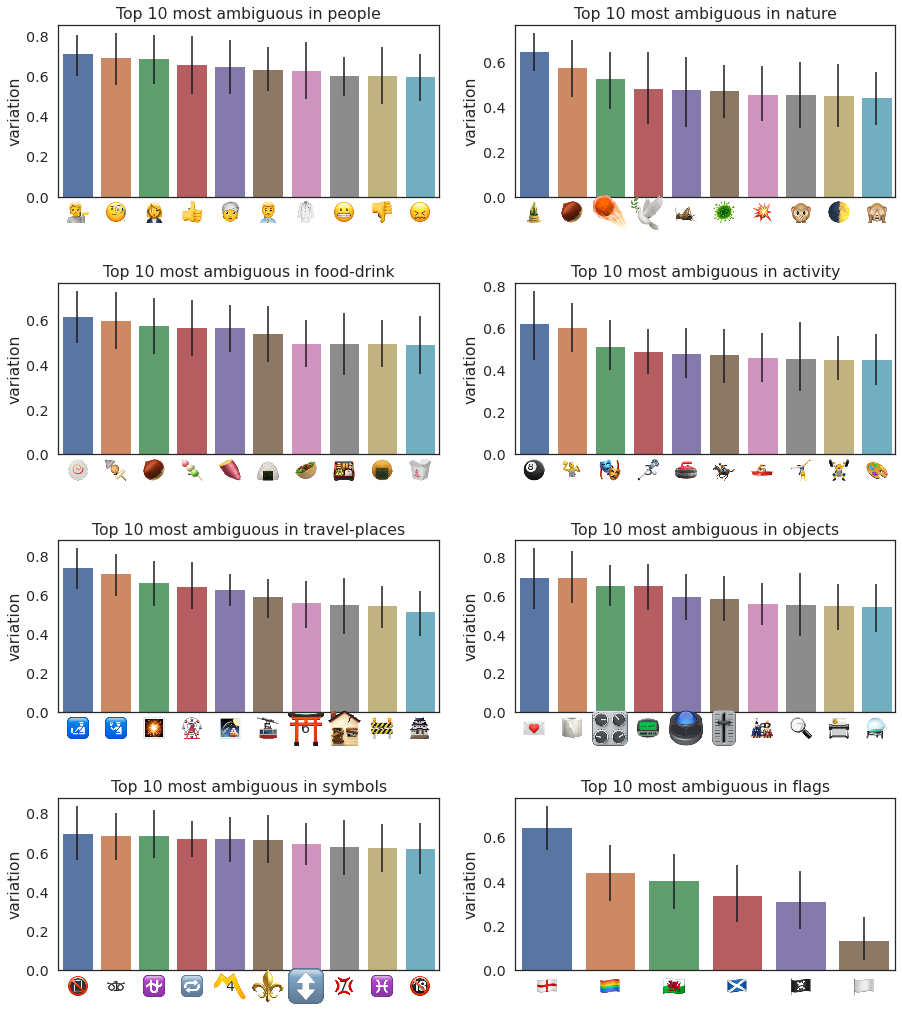

In [7]:
fig, axes = plt.subplots(4, 2)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        df = variations[variations.emoji.isin(categorized[category])]
        top_ten = df.sort_values("variation", ascending=False)[:10].reset_index()
        plot_emoji_barplot(top_ten, ax, col='variation', cluster=True)
        ax.set_title(f"Top 10 most ambiguous in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2)

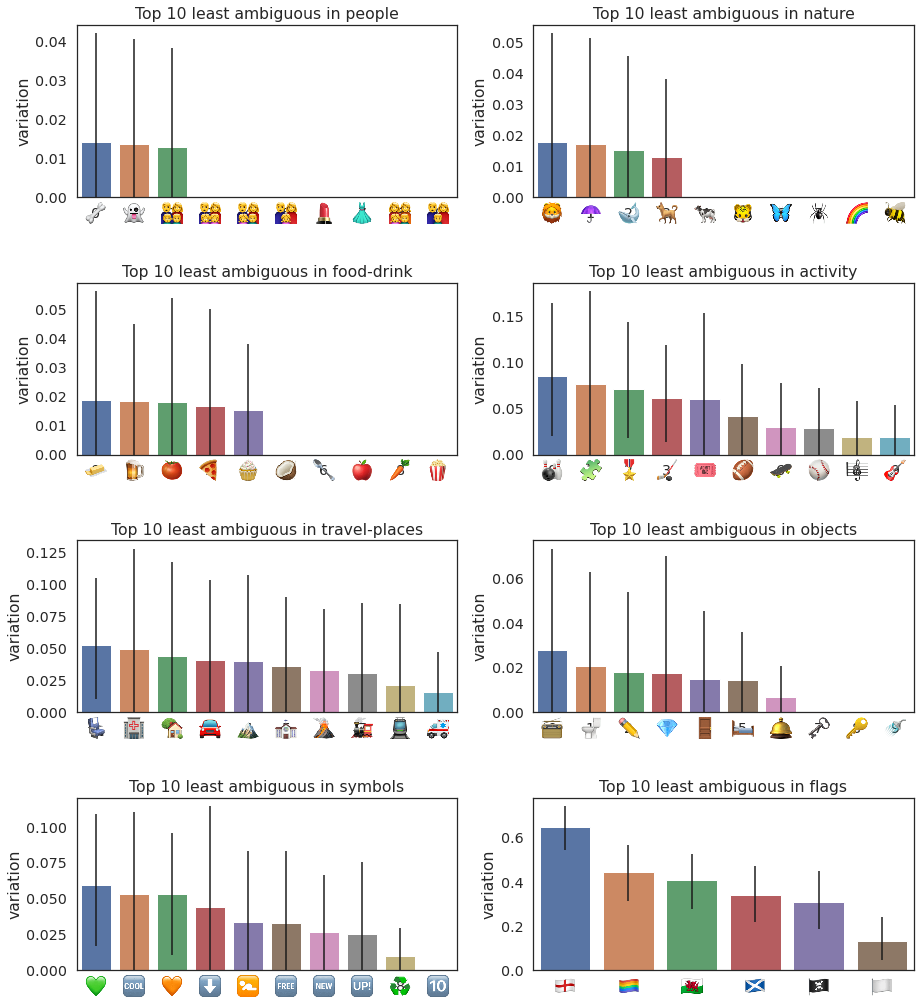

In [8]:
fig, axes = plt.subplots(4, 2)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        category = emoji_categories[i*2+j]
        df = variations[variations.emoji.isin(categorized[category])]
        top_ten = df.sort_values("variation", ascending=False)[-10:].reset_index()
        plot_emoji_barplot(top_ten, ax, col='variation', cluster=True)
        ax.set_title(f"Top 10 least ambiguous in {category}")
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=2)

In [ ]:
fig, ax = plt.subplots()
df = variations
for x, y, emoji in zip(df['variation'], df['vocab_size'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.set_xlabel("variation")
ax.set_ylabel("Vocabulary size");

In [10]:
baseline = 0.6861290227621794
baselines_CIs = [0.5707602351453775, 0.8834659105717826]

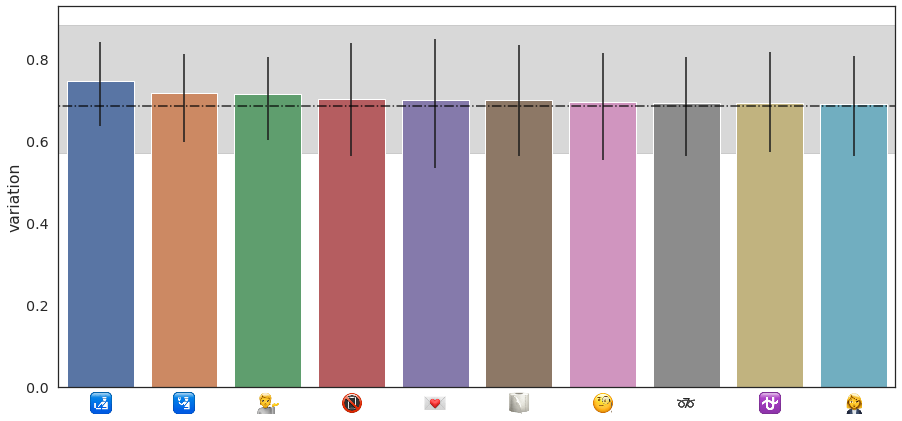

In [11]:
fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
top_ten = variations.sort_values(by='variation', ascending=False)[:10].reset_index()
plot_emoji_barplot(top_ten, ax, col='variation', cluster=True)

In [ ]:
top_ten

In [6]:
# variations = pd.read_csv("/scratch/czestoch/bert_masked_emojis_variances.csv.gz")
# variations.head()

,emoji,variance
0,©️,1.997789
1,®️,2.015507
2,‼️,2.036579
3,⁉️,2.027594
4,™️,1.714779


In [7]:
def assign_category(emoji):
    for category in categorized:
        if emoji in categorized[category]:
            return category

In [12]:
variations["category"] = variations.emoji.apply(assign_category)

In [13]:
variations = variations[variations.category != "flags"]

In [14]:
baseline = 2.141998551091523
baselines_CIs = [1.8021563414149595, 2.4626271965653945]

In [15]:
baselines_CIs

[1.8021563414149595, 2.4626271965653945]

In [17]:
variations1 = variations[variations.variance < baselines_CIs[0]]

In [18]:
variations1.category.value_counts()

people           39
objects          20
travel-places    17
symbols          17
nature           17
food-drink       14
activity         10
Name: category, dtype: int64

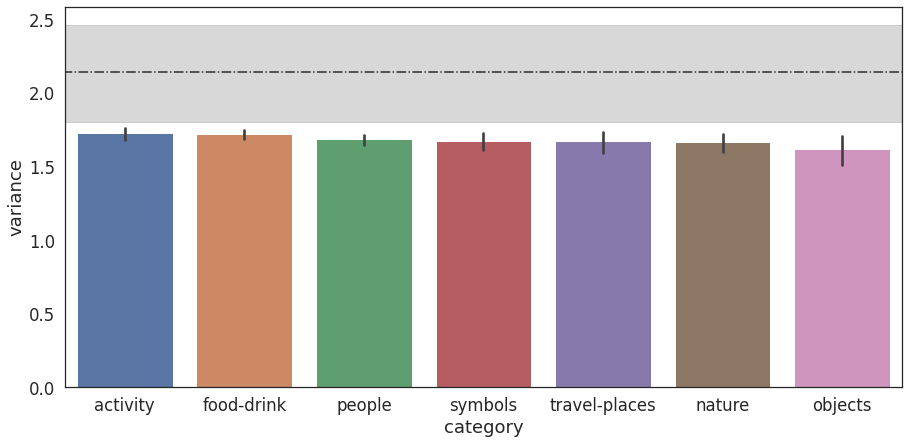

In [31]:
order = variations1.groupby("category").variance.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
sns.barplot(x='category', y='variance', data=variations1, ax=ax, order=order);

In [ ]:
variations[variations.emoji.isin(top_ten.emoji)].category.value_counts()

In [26]:
asian_signs = ['🈂️','🈚','🈯','🈲','🈳','🈴','🈵','🈶','🈷️','🈸',\
               '🈹','🈺','🉐','🉑','㊗️','㊙️','🀄']
astrological = ['♈','♉','♊','♋','♌','♍','♎','♏','♐','♑','♒','♓', '⛎']
religious = ['🕉️', '🕎', '☦️','☪️','☯️', '✝️','✡️']
hearts = ['💓','💔','💕','💖','💗','💘','💙','💚','💛','💜','💝','💞','💟']


others = set(variations[variations.category == "symbols"].emoji.unique()) \
                - set(asian_signs) - set(astrological) - set(religious) - set(hearts)

symbols_subcategories = {"asian_signs": asian_signs, "astrological": astrological,\
                        "religious": religious, "hearts": hearts, "others": others}

In [27]:
symbols_df = variations[variations.category == "symbols"]

def assign_subcategory(emoji):
    for subcategory in symbols_subcategories:
        if emoji in symbols_subcategories[subcategory]:
            return subcategory

symbols_df["subcategory"] = symbols_df.emoji.apply(assign_subcategory)

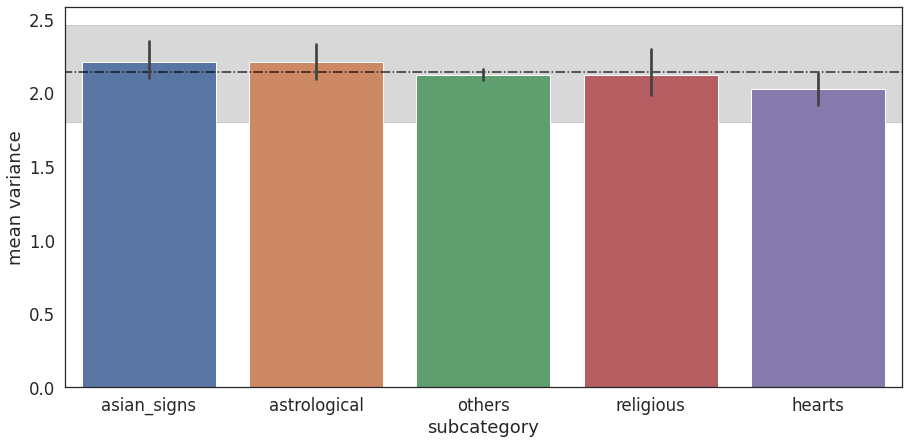

In [30]:
order = symbols_df.groupby("subcategory").variance.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
sns.barplot(x='subcategory', y='variance', data=symbols_df, ax=ax, order=order)
ax.set_ylabel("mean variance");

In [ ]:
for _, vocab in symbols_df[symbols_df.subcategory =="astrological"].vocabulary.iteritems():
    print(vocab)
    print()

In [ ]:
for _, vocab in symbols_df[symbols_df.subcategory =="asian_signs"].vocabulary.iteritems():
    print(vocab)
    print()

In [ ]:
for _, em in variations[variations.category == "symbols"].emoji.iteritems():
    print("'" + em + "'" + ",")